In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round'])

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                 53
winner_hand              0
winner_ht               79
winner_age               3
loser_hand               1
loser_ht               227
loser_age                3
minutes               1033
w_ace                  694
w_df                   694
w_svpt                 694
w_1stIn                694
w_1stWon               694
w_2ndWon               694
w_SvGms                694
w_bpSaved              694
w_bpFaced              694
l_ace                  694
l_df                   694
l_svpt                 694
l_1stIn                694
l_1stWon               694
l_2ndWon               694
l_SvGms                694
l_bpSaved              694
l_bpFaced              694
winner_rank             79
winner_rank_points      79
loser_rank             222
loser_rank_points      222
dtype: int64
2
17547


## Convert Categorical Variables to Numerical

In [6]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [7]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',
    'w_SvGms': 'p1_SvGms',
    'w_bpSaved': 'p1_bpSaved',
    'w_bpFaced': 'p1_bpFaced',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
    'l_SvGms': 'p2_SvGms',
    'l_bpSaved': 'p2_bpSaved',
    'l_bpFaced': 'p2_bpFaced'
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
0    8797
1    8750
Name: count, dtype: int64


In [8]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,188.0,30.6,1,185.0,25.6,123.0,10.0,3.0,...,39.0,20.0,13.0,8.0,9.0,52.0,909.0,47.0,1010.0,1
1,2,1,188.0,21.2,1,183.0,23.7,90.0,5.0,3.0,...,25.0,7.0,9.0,7.0,11.0,54.0,890.0,94.0,593.0,0
2,2,1,175.0,25.6,1,185.0,31.3,145.0,8.0,6.0,...,48.0,12.0,14.0,9.0,11.0,30.0,1391.0,63.0,809.0,1
3,2,1,183.0,18.8,1,188.0,28.0,104.0,9.0,3.0,...,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0,0
4,2,1,188.0,19.9,0,193.0,27.2,69.0,5.0,4.0,...,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0,0


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,175.0,25.0,1,183.0,28.2,87.0,1.0,2.0,...,19.0,5.0,8.0,5.0,9.0,569.0,64.0,819.0,24.0,0
3066,2,1,178.0,31.0,1,188.0,28.8,65.0,4.0,2.0,...,17.0,9.0,8.0,2.0,5.0,279.0,205.0,900.0,18.0,0
3068,0,0,185.0,23.9,1,188.0,21.8,137.0,1.0,2.0,...,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0,0
3070,0,0,185.0,23.9,1,175.0,34.2,95.0,1.0,1.0,...,19.0,14.0,8.0,3.0,4.0,616.0,55.0,136.0,489.0,1
3074,2,1,185.0,27.3,1,175.0,26.9,159.0,5.0,3.0,...,41.0,13.0,14.0,2.0,5.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17547 entries, 0 to 3074
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17547 non-null  int64  
 1   p1_hand         17547 non-null  int64  
 2   p1_ht           17547 non-null  float64
 3   p1_age          17547 non-null  float64
 4   p2_hand         17547 non-null  int64  
 5   p2_ht           17547 non-null  float64
 6   p2_age          17547 non-null  float64
 7   minutes         17547 non-null  float64
 8   p1_ace          17547 non-null  float64
 9   p1_df           17547 non-null  float64
 10  p1_svpt         17547 non-null  float64
 11  p1_1stIn        17547 non-null  float64
 12  p1_1stWon       17547 non-null  float64
 13  p1_2ndWon       17547 non-null  float64
 14  p1_SvGms        17547 non-null  float64
 15  p1_bpSaved      17547 non-null  float64
 16  p1_bpFaced      17547 non-null  float64
 17  p2_ace          17547 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,1.304383,0.858152,187.271442,27.142121,0.863111,187.186015,27.132963,115.207215,6.356186,2.910469,...,35.948196,15.452727,12.621759,4.106457,6.713455,79.184191,1533.912920,79.847096,1523.422465,0.498661
std,0.893933,0.348904,6.945786,4.589073,0.343740,7.243650,4.555616,42.268962,5.537042,2.459177,...,14.124804,6.858096,4.211351,3.235602,4.439746,105.638422,1734.767544,110.512885,1713.490293,0.500012
min,0.000000,0.000000,163.000000,16.400000,0.000000,15.000000,16.700000,5.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,83.000000,2.000000,1.000000,...,26.000000,11.000000,10.000000,2.000000,3.000000,26.000000,644.000000,26.000000,644.500000,0.000000
50%,2.000000,1.000000,188.000000,26.700000,1.000000,188.000000,26.800000,108.000000,5.000000,2.000000,...,34.000000,14.000000,12.000000,3.000000,6.000000,55.000000,946.000000,55.000000,951.000000,0.000000
75%,2.000000,1.000000,193.000000,30.300000,1.000000,193.000000,30.300000,139.000000,9.000000,4.000000,...,44.000000,19.000000,15.000000,6.000000,9.000000,94.000000,1639.500000,94.000000,1631.500000,1.000000
max,2.000000,1.000000,211.000000,42.500000,1.000000,211.000000,42.300000,396.000000,67.000000,26.000000,...,171.000000,56.000000,50.000000,27.000000,35.000000,2146.000000,12415.000000,1921.000000,12415.000000,1.000000


In [9]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
minutes           0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p1_SvGms          0
p1_bpSaved        0
p1_bpFaced        0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p2_SvGms          0
p2_bpSaved        0
p2_bpFaced        0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [11]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17547


## Scale Features

In [13]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([1, 0, 1, ..., 0, 1, 1])

array([[ 0.77817611,  0.40656389,  0.10489502, ..., -0.36023889,
        -0.2972326 , -0.29964401],
       [ 0.77817611,  0.40656389,  0.10489502, ..., -0.37119167,
         0.12806929, -0.54301386],
       [ 0.77817611,  0.40656389, -1.76679686, ..., -0.08238394,
        -0.15244898, -0.41695178],
       ...,
       [-1.45919178, -2.45963802, -0.32703387, ..., -0.85253789,
         5.97370807, -0.86925786],
       [-1.45919178, -2.45963802, -0.32703387, ..., -0.85253789,
         0.5081263 , -0.60371042],
       [ 0.77817611,  0.40656389, -0.32703387, ..., -0.82140891,
         4.29059845, -0.84999838]])

## Split data into testing and training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 0, 1, ..., 1, 0, 0])

### Reusable function for evaluation

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(y_pred_test, y_pred_train):
  print("=== Test Metrics ===")
  accuracy_test = accuracy_score(y_test, y_pred_test)
  print(f"Accuracy: {accuracy_test}")

  precision_test = precision_score(y_test, y_pred_test, average='binary')
  print(f"Precision: {precision_test}")

  recall_test = recall_score(y_test, y_pred_test, average='binary')
  print(f"Recall: {recall_test}")

  f1_test = f1_score(y_test, y_pred_test, average='binary')
  print(f"F1 Score: {f1_test}")

  print("\n=== Training Metrics ===")
  accuracy_train = accuracy_score(y_train, y_pred_train)
  print(f"Accuracy: {accuracy_train}")

  precision_train = precision_score(y_train, y_pred_train, average='binary')
  print(f"Precision: {precision_train}")

  recall_train = recall_score(y_train, y_pred_train, average='binary')
  print(f"Recall: {recall_train}")

  f1_train = f1_score(y_train, y_pred_train, average='binary')
  print(f"F1 Score: {f1_train}")

  # Show the shape of training data
  print("\nX_train shape:", X_train.shape)

  # Confusion matrix for test data
  cm = confusion_matrix(y_test, y_pred_test)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix (Test Data)')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9495726495726495
Precision: 0.9487034949267192
Recall: 0.9513849632560769
F1 Score: 0.9500423370025403

=== Training Metrics ===
Accuracy: 0.9521265227612737
Precision: 0.9509649749821301
Recall: 0.9528720813637015
F1 Score: 0.9519175729822553

X_train shape: (14037, 30)


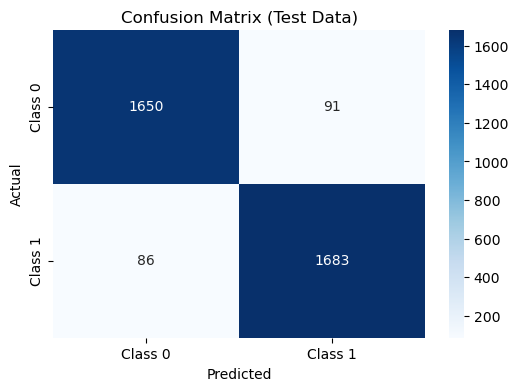

In [19]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Logistic Regression With Hypertuning

=== Test Metrics ===
Accuracy: 0.9495726495726495
Precision: 0.9481981981981982
Recall: 0.9519502543810062
F1 Score: 0.9500705218617772

=== Training Metrics ===
Accuracy: 0.9524114839353138
Precision: 0.9508641622625339
Recall: 0.9535883111302106
F1 Score: 0.9522242883707625

X_train shape: (14037, 30)


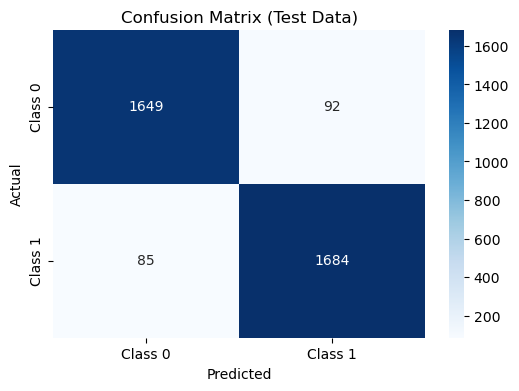

In [135]:
# Tried on this one but not much change, running gridsearch on all will blow up our computers

# testing elastic 
from sklearn.linear_model import LogisticRegression

log_manual = LogisticRegression(
    penalty="elasticnet",
    C=1.0,               # tune up (weaker) or down (stronger) if needed
    l1_ratio=0.5,        # 0 = pure L2, 1 = pure L1
    class_weight="balanced",
    solver="saga",       # saga supports elastic‑net
    max_iter=10000,
    random_state=42
)
log_manual.fit(X_train, y_train)

y_pred_test  = log_manual.predict(X_test)
y_pred_train = log_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)


### Bagging

=== Test Metrics ===
Accuracy: 0.949002849002849
Precision: 0.948645598194131
Recall: 0.9502543810062182
F1 Score: 0.9494493081050551

=== Training Metrics ===
Accuracy: 0.9520552824677637
Precision: 0.951345163136806
Recall: 0.9522990975504942
F1 Score: 0.951821891330804

X_train shape: (14037, 30)


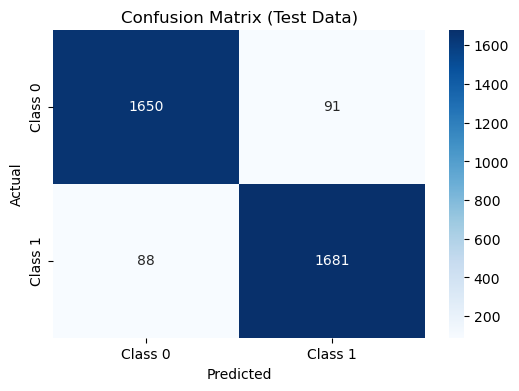

In [21]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9282051282051282
Precision: 0.9211549139367018
Recall: 0.9378179762577727
F1 Score: 0.9294117647058824

=== Training Metrics ===
Accuracy: 0.9348151314383415
Precision: 0.9275444037214547
Recall: 0.9425583727259705
F1 Score: 0.9349911190053286

X_train shape: (14037, 30)


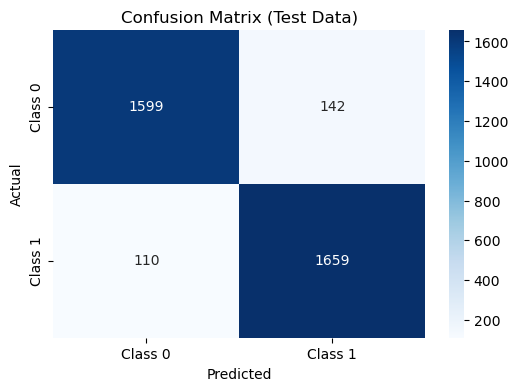

In [23]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## DecisionTreeClassifier

=== Test Metrics ===
Accuracy: 0.7695156695156695
Precision: 0.7651933701657458
Recall: 0.7829282080271339
F1 Score: 0.7739592064822576

=== Training Metrics ===
Accuracy: 0.7663318372871696
Precision: 0.758558055050999
Recall: 0.7776822804755765
F1 Score: 0.7680011317017966

X_train shape: (14037, 30)


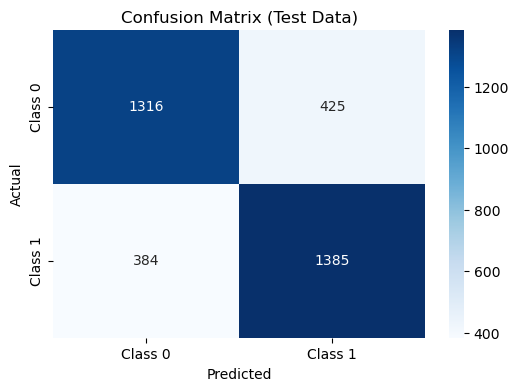

In [114]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### DecisionTreeClassifier with Hypertuning

=== Test Metrics ===
Accuracy: 0.827065527065527
Precision: 0.8143939393939394
Recall: 0.8507631430186546
F1 Score: 0.8321813657727398

=== Training Metrics ===
Accuracy: 0.8880814988957755
Precision: 0.8642607056288716
Recall: 0.9193525282910758
F1 Score: 0.890955785382106

X_train shape: (14037, 30)


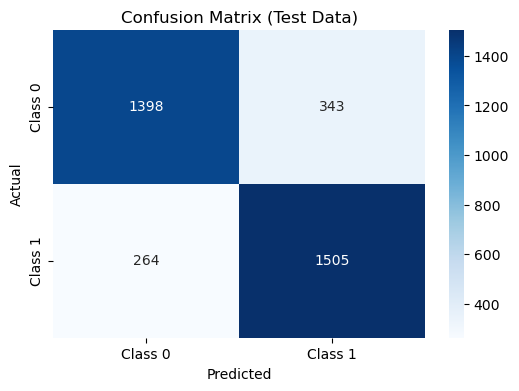

In [117]:
from sklearn.tree import DecisionTreeClassifier

dt_manual = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,          # try None, 5, 10, …
    min_samples_split=10,  # >2 forces larger internal nodes
    min_samples_leaf=5,    # >1 smooths leaves
    class_weight="balanced",
    random_state=42
)
dt_manual.fit(X_train, y_train)

y_pred_test  = dt_manual.predict(X_test)
y_pred_train = dt_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.7954415954415954
Precision: 0.817522658610272
Recall: 0.7648388920293951
F1 Score: 0.790303738317757

=== Training Metrics ===
Accuracy: 0.7980337678991237
Precision: 0.8164885496183206
Recall: 0.7660793582581292
F1 Score: 0.7904811174340404

X_train shape: (14037, 30)


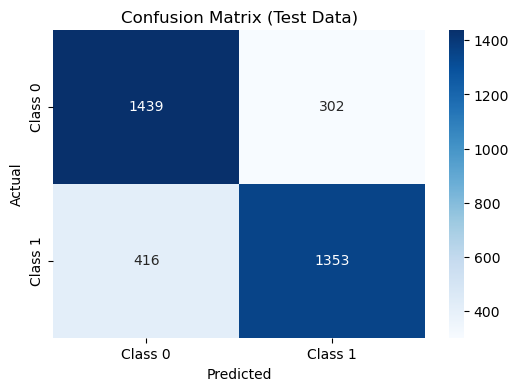

In [27]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9250712250712251
Precision: 0.9293044469783353
Recall: 0.9214245336348219
F1 Score: 0.9253477150156117

=== Training Metrics ===
Accuracy: 0.9653059770606255
Precision: 0.9675979262672811
Recall: 0.9624695602349234
F1 Score: 0.9650269299820466

X_train shape: (14037, 30)


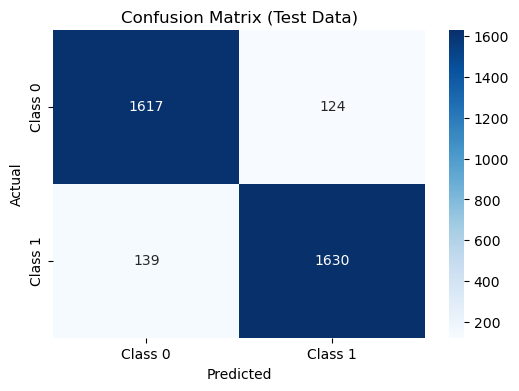

In [29]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Random Forest

=== Test Metrics ===
Accuracy: 0.8598290598290599
Precision: 0.8705745792222868
Recall: 0.847936687394008
F1 Score: 0.8591065292096219

=== Training Metrics ===
Accuracy: 0.9350288523188716
Precision: 0.939209726443769
Recall: 0.929522990975505
F1 Score: 0.934341252699784

X_train shape: (14037, 30)


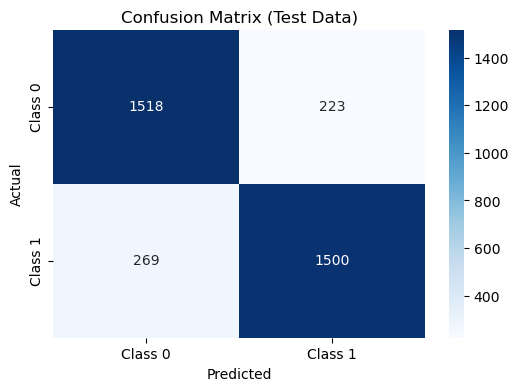

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Random Forest Hyptertuned

=== Test Metrics ===
Accuracy: 0.8786324786324786
Precision: 0.8856978747846066
Recall: 0.8716789146410401
F1 Score: 0.8786324786324786

=== Training Metrics ===
Accuracy: 0.99950131794543
Precision: 0.9991411394217006
Recall: 0.9998567540466982
F1 Score: 0.9994988186439464

X_train shape: (14037, 30)


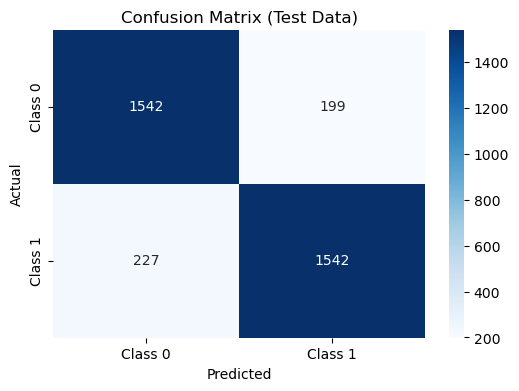

In [139]:
from sklearn.ensemble import RandomForestClassifier

rf_manual = RandomForestClassifier(
    n_estimators=300,          # more trees → stabler votes
    max_depth=None,           # let trees grow fully
    min_samples_split=5,      # >2 combats over‑fitting
    min_samples_leaf=2,       # each leaf must have ≥2 samples
    max_features="sqrt",      # standard RF setting for classification
    class_weight="balanced_subsample",  # handle any class skew per tree
    bootstrap=True,           # keep classic bootstrapping
    n_jobs=-1,                # all CPU cores
    random_state=42
)
rf_manual.fit(X_train, y_train)

y_pred_test  = rf_manual.predict(X_test)
y_pred_train = rf_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.8623931623931624
Precision: 0.8747086247086248
Recall: 0.8485019785189373
F1 Score: 0.8614060258249642

=== Training Metrics ===
Accuracy: 0.9248414903469402
Precision: 0.9310445155659005
Recall: 0.916774101131643
F1 Score: 0.9238542042583905

X_train shape: (14037, 30)


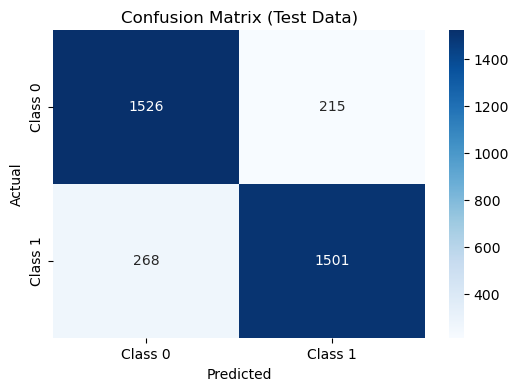

In [33]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9017094017094017
Precision: 0.9125144843568945
Recall: 0.8903335217637083
F1 Score: 0.9012875536480687

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


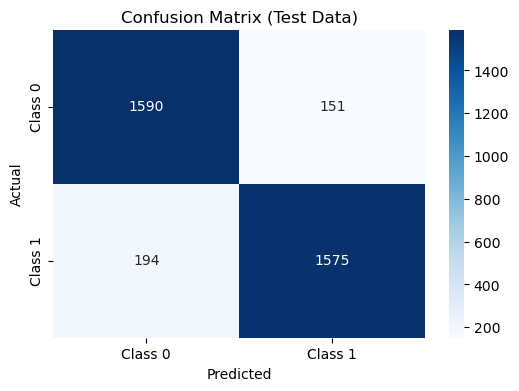

In [35]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## KNN

=== Test Metrics ===
Accuracy: 0.8210826210826211
Precision: 0.833041447752481
Recall: 0.8066704352741662
F1 Score: 0.8196438828259621

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


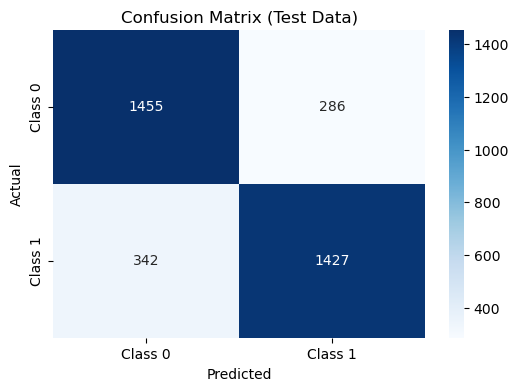

In [37]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### KNN With HyperTuning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ----------------------------------------------------------------
#  1) Split first, then scale (prevents leakage)
# ----------------------------------------------------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler   = StandardScaler().fit(X_train_raw)  # fit ONLY on training data
X_train  = scaler.transform(X_train_raw)
X_test   = scaler.transform(X_test_raw)


# --- 2) Hyper‑parameter grid --------------------------------------
param_grid = {
    "n_neighbors": [3,5,7,9,11,15,19,23,27,31],
    "weights":     ["uniform", "distance"],
    "metric":      ["euclidean", "manhattan"],
    "leaf_size":   [20, 30, 40, 60, 90],
    "algorithm":   ["auto", "brute"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_knn = GridSearchCV(
    estimator   = KNeighborsClassifier(),
    param_grid  = param_grid,
    cv          = cv,
    scoring     = "balanced_accuracy",
    n_jobs      = -1,
    verbose     = 2
)

# --- 3) Fit search ------------------------------------------------
grid_knn.fit(X_train, y_train)

print("Best hyper‑parameters:", grid_knn.best_params_)
print(f"CV balanced acc      : {grid_knn.best_score_:.4f}")

# --- 4) Evaluate on hold‑out test set -----------------------------
best_knn      = grid_knn.best_estimator_
y_pred_test   = best_knn.predict(X_test)
y_pred_train  = best_knn.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.7s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, weights=distance; total time=   0.5s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.9s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=5, weights=distance; total time=   0.4s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=5, weights=distance; total time=   0.4s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=7, weights=uniform; total time=   1.0s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=7, weights=distance; total time=   0.4s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=7, weights=distance; total time=   0.4s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbor

### Bagging

=== Test Metrics ===
Accuracy: 0.8623931623931624
Precision: 0.8747086247086248
Recall: 0.8485019785189373
F1 Score: 0.8614060258249642

=== Training Metrics ===
Accuracy: 0.9248414903469402
Precision: 0.9310445155659005
Recall: 0.916774101131643
F1 Score: 0.9238542042583905

X_train shape: (14037, 30)


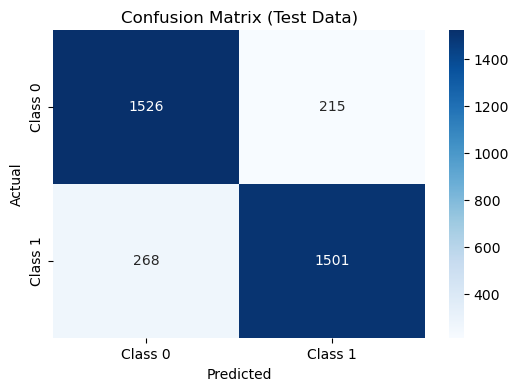

In [41]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9017094017094017
Precision: 0.9125144843568945
Recall: 0.8903335217637083
F1 Score: 0.9012875536480687

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


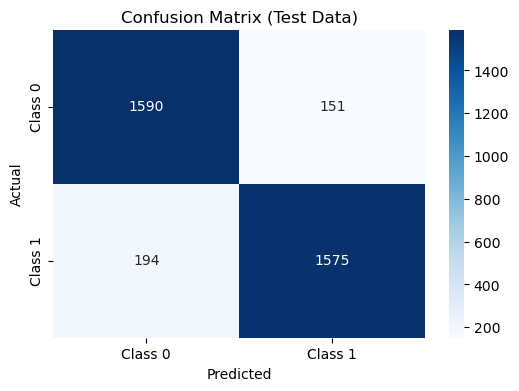

In [43]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Ball Tree

## KD Tree

## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.9501424501424501
Precision: 0.9497742663656885
Recall: 0.9513849632560769
F1 Score: 0.9505789325049421

=== Training Metrics ===
Accuracy: 0.9524114839353138
Precision: 0.9507353991146651
Recall: 0.9537315570835124
F1 Score: 0.9522311212814645

X_train shape: (14037, 30)


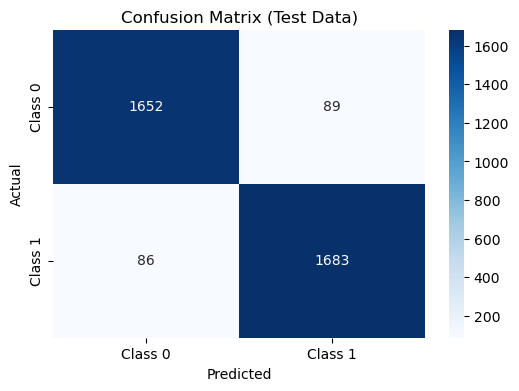

In [47]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9501424501424501
Precision: 0.9497742663656885
Recall: 0.9513849632560769
F1 Score: 0.9505789325049421

=== Training Metrics ===
Accuracy: 0.9522690033482938
Precision: 0.951107934238742
Recall: 0.9530153273170033
F1 Score: 0.9520606754436176

X_train shape: (14037, 30)


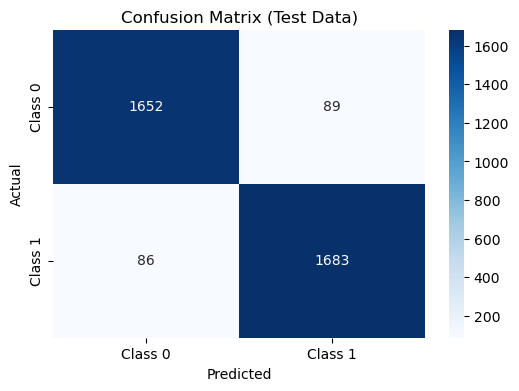

In [49]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9387464387464387
Precision: 0.9475806451612904
Recall: 0.929903900508762
F1 Score: 0.9386590584878745

=== Training Metrics ===
Accuracy: 0.9345301702643015
Precision: 0.9444281524926686
Recall: 0.9226471852170176
F1 Score: 0.9334106224186653

X_train shape: (14037, 30)


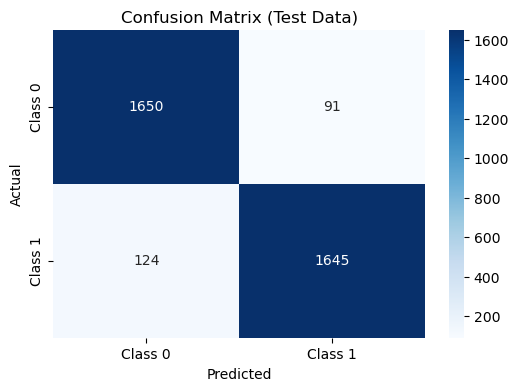

In [51]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.9398860398860399
Precision: 0.9381327334083239
Recall: 0.9429055963821368
F1 Score: 0.9405131096701438

=== Training Metrics ===
Accuracy: 0.961601481798105
Precision: 0.961461318051576
Recall: 0.9613235926085089
F1 Score: 0.961392450397536

X_train shape: (14037, 30)


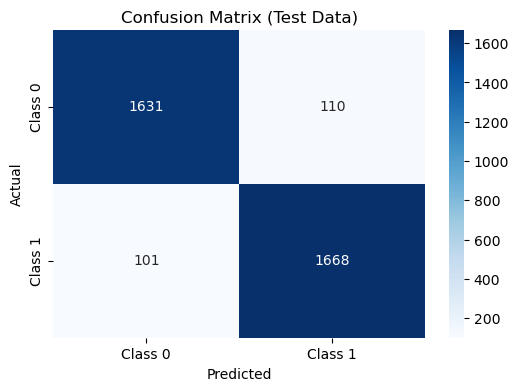

In [53]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9376068376068376
Precision: 0.9403409090909091
Recall: 0.9355568117580554
F1 Score: 0.9379427599886654

=== Training Metrics ===
Accuracy: 0.9618864429721451
Precision: 0.9649451817657242
Recall: 0.9581721816358688
F1 Score: 0.9615467548336089

X_train shape: (14037, 30)


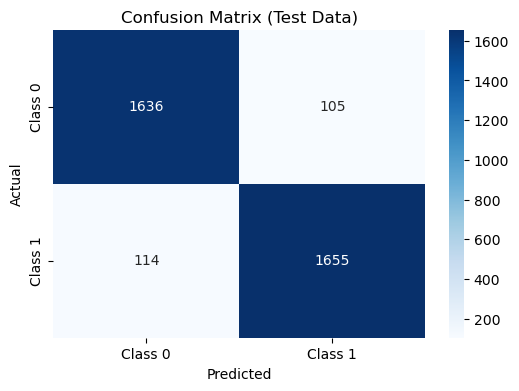

In [55]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.868091168091168
Precision: 0.8761520737327189
Recall: 0.8598078010175241
F1 Score: 0.8679029957203994

=== Training Metrics ===
Accuracy: 0.9897413977345587
Precision: 0.9892657793044225
Recall: 0.9901160292221745
F1 Score: 0.9896907216494846

X_train shape: (14037, 30)


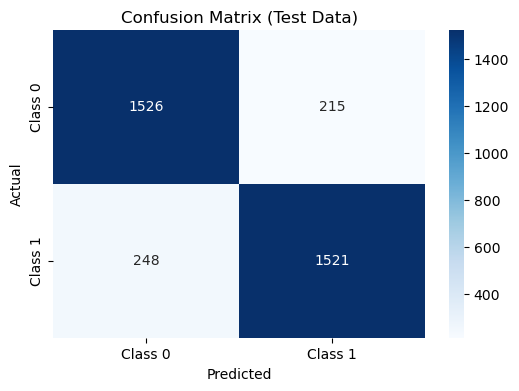

In [58]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9299145299145299
Precision: 0.9304691916336914
Recall: 0.9304691916336914
F1 Score: 0.9304691916336914

=== Training Metrics ===
Accuracy: 0.9294008691315808
Precision: 0.9295754446356856
Recall: 0.9283770233490903
F1 Score: 0.9289758474879954

X_train shape: (14037, 30)


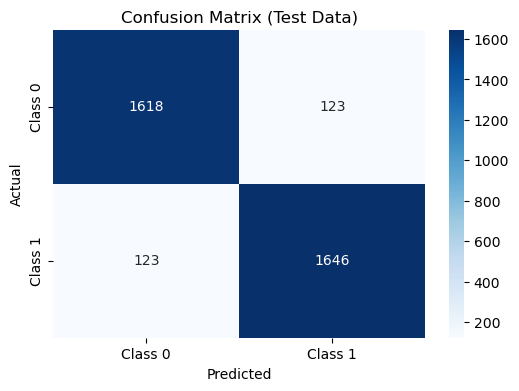

In [60]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Gaussian SVC & Decision Tree -> Logistic

=== Test Metrics ===
Accuracy: 0.9396011396011396
Precision: 0.9380979178390546
Recall: 0.9423403052572075
F1 Score: 0.9402143260011281

=== Training Metrics ===
Accuracy: 0.9630262876683052
Precision: 0.9624964214142571
Recall: 0.9631857900014325
F1 Score: 0.9628409823154579

X_train shape: (14037, 30)


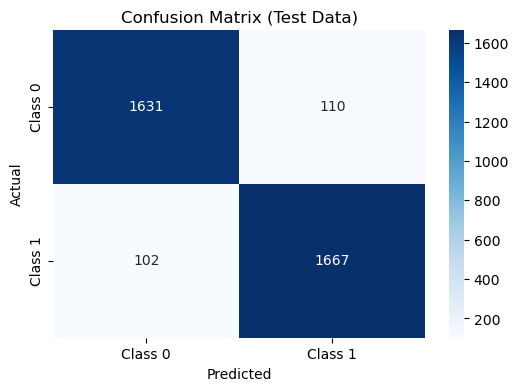

In [62]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)